In [2]:
# # Install needed libraries
# !python -m pip install import_ipynb 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from crunch_func import *

In [3]:
try:
    engine_df = pd.read_csv("EngineData.txt", sep='\t')
except FileNotFoundError:
        print("Engine Data file found. Make sure file is in same directory and name is correct.")

In [4]:
def get_tc_list(df, consec_crankv, bound):
    cycles = 0
    max_consec_crank = 0
    # Getting Top Center Points
    tc_list = []
    v_count = 1
    for i in range(len(df)):
        if v_count > max_consec_crank:
            max_consec_crank = v_count
        if (v_count == 1) & (df['crank_v'].iloc[i] < bound):
            tc_start = df.index[i]
        if (df['crank_v'].iloc[i-1] < bound) & (df['crank_v'].iloc[i] < bound):
            v_count += 1
        if (v_count >= consec_crankv) & (df['crank_v'].iloc[i] > bound):
            tc_list.append(tc_start)
            v_count = 1
            cycles += 1
        if df['crank_v'].iloc[i] > bound:
            v_count = 1 
    if cycles == 0:
        print(f"{consec_crankv} consecutive {bound}V Crank angle readings not found")
        print(f"Longest recuring voltage reading below {bound} is {max_consec_crank}")
        print("Top Center Points Not Found")
        return []
    print("Top Center Points Found")
    return tc_list

def get_rel_angs(df,consec_crank_times,consec_crankv):
    tc_list = get_tc_list(df, consec_crank_times, consec_crankv)
    ang_dic = {
        "tc_0":[],
        "tc_360":[],
        "tc_720":[],
    }
    count = 0
    for i in tc_list:
        if count == 0:
            ang_dic['tc_720'] += [i]
            ang_dic['tc_0'] += [i+1]
            count += 1
            continue
        elif count == 1:
            ang_dic['tc_360'] += [i]     
            count = 0
            continue   

    for index in ang_dic["tc_0"]:
        df.loc[index, 'state'] = 'tc_0'
        
    for index in ang_dic["tc_360"]:
        df.loc[index, 'state'] = 'tc_360'

    for index in ang_dic["tc_720"]:
        df.loc[index, 'state'] = 'tc_720'

    df.loc[df['state'] == "tc_0", 'rel_crank_ang'] = 0
    df.loc[df['state'] == "tc_360", 'rel_crank_ang'] = 360
    df.loc[df['state'] == "tc_720", 'rel_crank_ang'] = 720

    tc_list = ang_dic['tc_0'] + ang_dic["tc_360"] + ang_dic["tc_720"]
    tc_list.sort()

    for i in range(len(tc_list)):
        if i == len(tc_list) - 1:
            continue
        index = tc_list[i]
        ang1 =  df.loc[df.index[tc_list[i]], 'rel_crank_ang']
        dp1 = tc_list[i]
        ang2 = df.loc[df.index[tc_list[i+1]], 'rel_crank_ang']
        dp2 = tc_list[i+1]
        slope = (ang2 - ang1)/(dp2-dp1)
        points_to_inter = dp2 - dp1
        for inter_point in range(points_to_inter):
            inter_ang = ang2-(slope*(dp2 - (dp1 + inter_point)))
            df.loc[df.index[dp1 + inter_point],'rel_crank_ang'] = inter_ang

    df.dropna(subset=['rel_crank_ang'])
    df = scale_pressure(df)
    return df


In [10]:
print("*** DATA SET 1700 ***")
cd1700 = pd.read_csv('1700_001.txt',  sep='\t', names=['time', 'crank_v', 'pressure_v'])
cd1700_clean = get_rel_angs(cd1700, 9, 0.2)
eng1_data = engine_df.iloc[0]
load = eng1_data["Load"]
espeed = eng1_data["Engine Speed (rpm)"]
torque = eng1_data["Torque (lb-f)"]
power = eng1_data["Power (hp)"]
time_2_leave = eng1_data["Time for 0.488 L of fuel to leave Burette (s)"]
air_flow_rate = eng1_data["Air Flow Rate (CFM)"]
air_in_temp = eng1_data["Air Intake Temperature (F)"]
print('Engine Data Loaded')
cd1700_clean.to_csv('clean_1700.csv', index=False)
print('Created new CSV with cleaned crunched data')

*** DATA SET 1700 ***
Top Center Points Found
Engine Data Loaded
Created new CSV with cleaned crunched data


In [9]:
print("Load: ", load)
print("Engine Speed (rpm): ", espeed)
print("Torque (lb-f): ", torque)
print("Power (hp): ", power)
print("Time for 0.488 L of fuel to leave Burette (s): ", time_2_leave)
print("Air Flow Rate (CFM): ", air_flow_rate)


Load:  1.0
Engine Speed (rpm):  1320.0
Torque (lb-f):  210.0
Power (hp):  52.0
Time for 0.488 L of fuel to leave Burette (s):  105.41
Air Flow Rate (CFM):  76.0


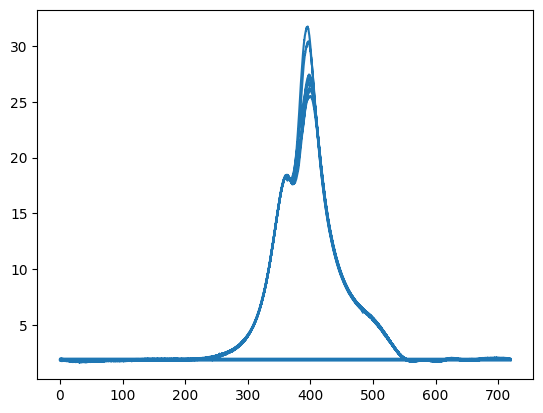

In [125]:
plt.plot(cd1700_clean['rel_crank_ang'], cd1700_clean['pressure_bar'])

*** DATA SET 2730 ***
Top Center Points Found
Created new CSV with cleaned crunched data
Load:  2.0
Engine Speed (rpm):  2600.0
Torque (lb-f):  230.0
Power (hp):  114.0
Time for 0.488 L of fuel to leave Burette (s):  50.26
Air Flow Rate (CFM):  162.0


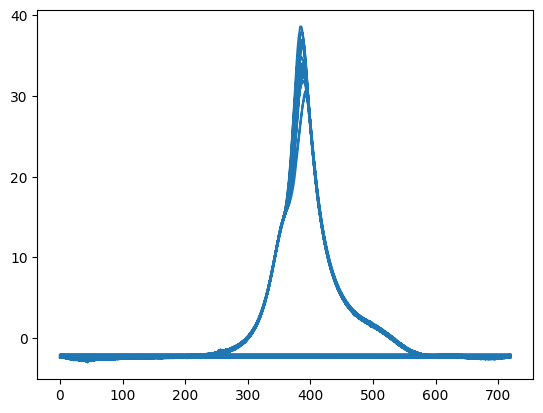

In [13]:
print("*** DATA SET 2730 ***")
cd2730 = pd.read_csv('2750_001.txt',  sep='\t', names=['time', 'crank_v', 'pressure_v'])
cd2730_clean = get_rel_angs(cd2730, 5, 0.3)
eng2_data = engine_df.iloc[1]
load = eng2_data["Load"]
espeed = eng2_data["Engine Speed (rpm)"]
torque = eng2_data["Torque (lb-f)"]
power = eng2_data["Power (hp)"]
time_2_leave = eng2_data["Time for 0.488 L of fuel to leave Burette (s)"]
air_flow_rate = eng2_data["Air Flow Rate (CFM)"]
air_in_temp = eng2_data["Air Intake Temperature (F)"]
# print('Engine Data Loaded')
cd2730_clean.to_csv('clean_2730.csv', index=False)
print('Created new CSV with cleaned crunched data')
plt.plot(cd2730_clean['rel_crank_ang'], cd2730_clean['pressure_bar'])
print("Load: ", load)
print("Engine Speed (rpm): ", espeed)
print("Torque (lb-f): ", torque)
print("Power (hp): ", power)
print("Time for 0.488 L of fuel to leave Burette (s): ", time_2_leave)
print("Air Flow Rate (CFM): ", air_flow_rate)


In [12]:
print("*** DATA SET cd4500 ***")
cd4500 = pd.read_csv('4500_001.txt',  sep='\t', names=['time', 'crank_v', 'pressure_v'])
cd4500_clean = get_rel_angs(cd4500, 6, 4)
eng3_data = engine_df.iloc[2]
load = eng3_data["Load"]
espeed = eng3_data["Engine Speed (rpm)"]
torque = eng3_data["Torque (lb-f)"]
power = eng3_data["Power (hp)"]
time_2_leave = eng3_data["Time for 0.488 L of fuel to leave Burette (s)"]
air_flow_rate = eng3_data["Air Flow Rate (CFM)"]
air_in_temp = eng3_data["Air Intake Temperature (F)"]
print('Engine Data Loaded')
### Since data starts at mid cycle when crank angle is at 360, not 0 or 720, need to shift the data by one phase, did not use function


*** DATA SET cd4500 ***
Top Center Points Found
Engine Data Loaded


In [14]:
df = pd.read_csv('4500_001.txt',  sep='\t', names=['time', 'crank_v', 'pressure_v'])
tc_list = get_tc_list(df, 5, 0.25)
print(len(tc_list))
ang_dic = {
    "tc_0":[],
    "tc_360":[],
    "tc_720":[],
}
count = 0
for i in tc_list:
    if count == 0:
        ang_dic['tc_360'] += [i]
        count += 1
        continue
    elif count == 1:
        ang_dic['tc_720'] += [i]   
        ang_dic['tc_0'] += [i+1]  
        count = 0
        continue   

for index in ang_dic["tc_0"]:
    df.loc[index, 'state'] = 'tc_0'
    
for index in ang_dic["tc_360"]:
    df.loc[index, 'state'] = 'tc_360'

for index in ang_dic["tc_720"]:
    df.loc[index, 'state'] = 'tc_720'

df.loc[df['state'] == "tc_0", 'rel_crank_ang'] = 0
df.loc[df['state'] == "tc_360", 'rel_crank_ang'] = 360
df.loc[df['state'] == "tc_720", 'rel_crank_ang'] = 720

tc_list = ang_dic['tc_0'] + ang_dic["tc_360"] + ang_dic["tc_720"]
tc_list.sort()
for i in range(len(tc_list)):
    if i == len(tc_list) - 1:
        continue
    index = tc_list[i]
    ang1 =  df.loc[df.index[tc_list[i]], 'rel_crank_ang']
    dp1 = tc_list[i]
    ang2 = df.loc[df.index[tc_list[i+1]], 'rel_crank_ang']
    dp2 = tc_list[i+1]
    slope = (ang2 - ang1)/(dp2-dp1)
    points_to_inter = dp2 - dp1
    for inter_point in range(points_to_inter):
        inter_ang = ang2-(slope*(dp2 - (dp1 + inter_point)))
        df.loc[df.index[dp1 + inter_point],'rel_crank_ang'] = inter_ang
df.dropna(subset=['rel_crank_ang'])
cd4500_clean = scale_pressure(df)
cd4500_clean.to_csv('clean_4500.csv', index=False)
print('Created new CSV with cleaned crunched data')

Top Center Points Found
54
Created new CSV with cleaned crunched data


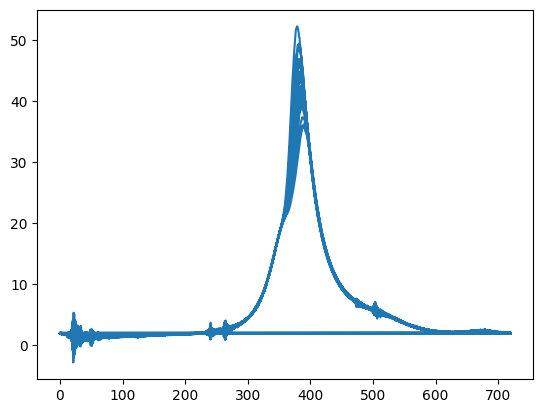

In [15]:
plt.plot(cd4500_clean['rel_crank_ang'], cd4500_clean['pressure_bar'])